In [1]:
# NB need to use environment with python3.9 or above for ccf_streamlines to run
import nrrd
import numpy as np
import matplotlib.pyplot as plt
import ccf_streamlines.projection as ccfproj
import pathlib
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import copy
import seaborn as sb
import nrrd
#from preprocessing_sequencing import preprocess_sequences as ps
from bg_atlasapi import BrainGlobeAtlas
#from final_processing import final_processing_functions as fpf
import ast
import yaml
from scipy.ndimage import zoom
%matplotlib inline

In [2]:
def load_parameters(directory):
    """Load the parameters yaml file containing all the parameters required for
    preprocessing MAPseq data

    Args:
    directory (str): Directory where to load parameters from. Default 'root' for the
        default parameters (found in `mapseq_preprocessing/parameters.py`).

    Returns:
        dict: contents of parameters.yml
    """

    def flatten_dict(d):
        flattened_dict = {}
        for key, value in d.items():
            if isinstance(value, dict):
                for subkey, subvalue in value.items():
                    flattened_dict[subkey] = subvalue
            else:
                flattened_dict[key] = value
        return flattened_dict

    if directory == "root":
        parameters_file = pathlib.Path(__file__).parent / "parameters.yml"
    else:
        parameters_file = pathlib.Path(directory) / "parameters.yml"
    with open(parameters_file, "r") as f:
        parameters = flatten_dict(yaml.safe_load(f))
    return parameters

def get_z_value(parameters_path, euclidean):
    """
    Function to get z value for each section, so you can calculate volumes.
    Args:
        parameters_path(str): path to where parameters yaml file is
        lcm_dir (str): where parent LCM directory is
        euclidean (str): true if you want to calculate z from median z difference between nearest 2d pixels in previous sections, 'no' if just want to crudely take average of subtraction of z between sections
        s: 'upper' or 'lower'. Whether the start of the section 's{num}' is capitalised or not. e.g. s001 or S001
    Returns:
        table containing z projections
    """
    # iterate through individual slices, take average difference in in coordinates in z (which is x axes in allen ccf) for last slice (slice s001 for brain 1), take average of previous slices
    parameters = load_parameters(directory=parameters_path)
    lcm_dir = pathlib.Path(parameters["lcm_directory"])
    s = parameters["s"]
    add_z = pd.DataFrame(columns=["slice", "amountz"], dtype=int)
    # need to change for mega thick last bit of cortex section, so extend ROI through 3slices
    saving_path = pathlib.Path(lcm_dir) / "allenccf/z_calc"
    allen_ccf_path = pathlib.Path(lcm_dir) / "allenccf/allen_ccf_coord"
    pathlib.Path(saving_path).mkdir(parents=True, exist_ok=True)
    sections_with_nothing_before = []
    if s == "upper":
        section_start = "S"
    else:
        section_start = "s"
    for file in os.listdir(allen_ccf_path):
        if file.startswith("allen_ccf_converted_"):
            slice_name = file[20:24]
            slicenum = int(file[21:24])
            slice_before = slicenum + 1
            if slice_before > 9:
                slicebefore_name = f"{section_start}0{slice_before}"
            if slice_before < 10:
                slicebefore_name = f"{section_start}00{slice_before}"
            [x1a, y1a, z1a, one1] = np.load(allen_ccf_path / file)
            if pathlib.Path(
                allen_ccf_path / f"allen_ccf_converted_{slicebefore_name}.npy"
            ).exists():
                if euclidean == False:
                    [x1a, y1a, z1a, one1] = np.load(allen_ccf_path / file)
                    [x2a, y2a, z2a, one2] = np.load(
                        allen_ccf_path / f"allen_ccf_converted_{slicebefore_name}.npy"
                    )
                    dif = np.median(x2a.flatten()) - np.median(x1a.flatten())
                    add_z = add_z.append(
                        {"slice": slice_name, "amountz": dif}, ignore_index=True
                    )
                if euclidean == True:
                    eucl_dist = np.load(
                        saving_path / f"euclid_distance_{slice_name}.npy"
                    )
                    z_dist = np.load(saving_path / f"z_add_{slice_name}.npy")
                    # now find the median z_distances for top 20% of the array with the lowest euclidean distance
                    flattened_indices = np.argsort(eucl_dist, axis=None)
                    num_lowest_20_percent = int(len(flattened_indices) * 0.2)
                    lowest_indices = np.unravel_index(
                        flattened_indices[:num_lowest_20_percent], eucl_dist.shape
                    )
                    dif = np.mean(z_dist[lowest_indices])
                    add_z = add_z.append(
                        {"slice": slice_name, "amountz": dif}, ignore_index=True
                    )
            else:
                sections_with_nothing_before.append(slice_name)
    # for slices where the one's before are missing, extend them by the mean of slice z extensions for the others
    median_z = add_z["amountz"].median()
    for slice in sections_with_nothing_before:
        add_z = add_z.append({"slice": slice, "amountz": median_z}, ignore_index=True)
    return add_z


In [3]:
mice = ['FIAA45.6a', 'FIAA45.6d']
roi_dict = {}
sample_vol_and_regions = {}
parameters_dict = {}
barcodes_dict = {}
scaling_factor = 25 / 10  # since we need in 10um resolution, we need to convert 25um resolution registered cubelets to 10um
zoom_factors = (scaling_factor, scaling_factor, scaling_factor)
for mouse in mice:
    lcm_directory = pathlib.Path(
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM"
    )
    # load datasets
    barcodes_across_sample = pd.read_pickle(
        f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/A1_barcodes_thresholded_with_source.pkl"
    )
    barcodes_dict[mouse] = barcodes_across_sample[barcodes_across_sample.sum(axis=1)>0]
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    not_in = [x for x in np.unique(ROI_3D) if x not in barcodes_across_sample.columns and x != 0]
    ROI_3D[np.isin(ROI_3D, not_in)] = 0
    sample_vol_and_regions[mouse] =pd.read_pickle(lcm_directory/'sample_vol_and_regions.pkl')
    parameters_dict[mouse] = load_parameters(directory=f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/")
    mask = np.isin(ROI_3D, parameters_dict[mouse]['cortical_samples'])
    ROI_3D[~mask] = 0
    roi_dict[mouse] = zoom(ROI_3D, zoom=zoom_factors, order=0)
    # A1 = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    # barcodes_across_sample = barcodes_across_sample[barcodes_across_sample.idxmax(axis=1).isin(A1)]


In [4]:
# this is the path to where the ccf streamlines downloads is (so don't change when looking a different mice)
convert_to_flat_path = pathlib.Path(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration"
)
annotation_data = nrrd.read("/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/flatmap_butterfly.nrrd")
labels_df =  pd.read_csv(
            "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/labelDescription_ITKSNAPColor.txt",
            header=None,
            sep="\s+",
            index_col=0
        )
labels_df.columns = ["r", "g", "b", "x0", "x1", "x2", "acronym"]
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path / "flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path / "labelDescription_ITKSNAPColor.txt",
)

# We get the left hemisphere region boundaries with the default arguments
bf_left_boundaries = bf_boundary_finder.region_boundaries()

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere="right_for_both",
    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere="flatmap_butterfly",
)
proj_top = ccfproj.Isocortex2dProjector(
    # Specify our view lookup file
    convert_to_flat_path / "flatmap_butterfly.h5",
    # Specify our streamline file
    convert_to_flat_path / "surface_paths_10_v3.h5",
    # Specify that we want to project both hemispheres
    hemisphere="both",
    # The top view contains space for the right hemisphere, but is empty.
    # Therefore, we tell the projector to put both hemispheres side-by-side
    view_space_for_other_hemisphere="flatmap_butterfly",
)

loading path information


100%|██████████| 1016/1016 [00:06<00:00, 147.16it/s]


In [5]:
#combine the two mice
combined_samples = ((roi_dict['FIAA45.6a'] > 0) | (roi_dict['FIAA45.6d'] > 0)).astype(int)
vis_barcodes = {}
for mouse in mice:
    VIS_samples = sample_vol_and_regions[mouse][sample_vol_and_regions[mouse].main.str.contains('VIS')]['ROI Number'].to_list()
    VIS_samples = [sample for sample in VIS_samples if sample in barcodes_dict[mouse].columns]
    barcodes_across_sample =barcodes_dict[mouse]
    vis_barcodes[mouse] =barcodes_dict[mouse][barcodes_dict[mouse][VIS_samples].ne(0).any(1)]


a = ['FIAA45.6a' for _ in range(len(vis_barcodes['FIAA45.6a']))]
d = ['FIAA45.6d' for _ in range(len(vis_barcodes['FIAA45.6d']))]
a.extend(d)
combined_barcodes_mouse = pd.DataFrame({'mouse': a})
#combined_all_barcodes= pd.concat([vis_barcodes['FIAA45.6a'], vis_barcodes['FIAA45.6d']])


/tmp/ipykernel_3719617/3861842901.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  vis_barcodes[mouse] =barcodes_dict[mouse][barcodes_dict[mouse][VIS_samples].ne(0).any(1)]
/tmp/ipykernel_3719617/3861842901.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  vis_barcodes[mouse] =barcodes_dict[mouse][barcodes_dict[mouse][VIS_samples].ne(0).any(1)]


In [6]:
ref_anno =  nrrd.read('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/reference/annotation_25.nrrd')
allen_anno = np.array(ref_anno)
annotation = allen_anno[0]
barcode_index = np.random.randint(len(combined_barcodes_mouse))
mouse = combined_barcodes_mouse.iloc[barcode_index]['mouse']
resolution =25
if mouse=='FIAA45.6d':
    adjusted_bc_ind = barcode_index-len(vis_barcodes['FIAA45.6a'])
else:
    adjusted_bc_ind = barcode_index

barcodes_across_sample =vis_barcodes[mouse]

lcm_directory = parameters_dict[mouse]['lcm_directory']
empty_frame = np.zeros((528, 320, 456))
ROI_path = pathlib.Path(lcm_directory) / "rois"
reg_dir = pathlib.Path(lcm_directory) / "allenccf/allen_ccf_coord"
add_z = get_z_value(
        parameters_path=f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/", euclidean= parameters_dict[mouse]["euclidean"]
    )
s = parameters_dict[mouse]["s"]
if s == "upper":
    section_start = "S"
else:
    section_start = "s"
for sample in barcodes_across_sample.columns:
    if barcodes_across_sample.iloc[adjusted_bc_ind][sample] > 0:
        for ROI_to_look in os.listdir(ROI_path):
            region = ROI_path / ROI_to_look
            if ROI_to_look.startswith("s0") or ROI_to_look.startswith("S0"):
                slicename = region.stem[1:4]
                tube = int(region.stem[5 : len(region.stem)].split("TUBE", 1)[1])
                # some of the roi's are pooled due to missing lcm images that are too hard to determine, these are specified in parameters file. We group these into one sample
                for tube_to_group in parameters_dict[mouse]["rois_to_combine"]:
                    if tube in parameters_dict[mouse]["rois_to_combine"][tube_to_group]:
                        tube = tube_to_group
                if tube ==sample:
                # if int(tube) in cortical_samples_table['Tube'].to_list():
                    [xa, ya, za, one] = np.load(
                        reg_dir / f"allen_ccf_converted_{section_start}{slicename}.npy"
                    )
                    roi = plt.imread(ROI_path / f"{region}")
                    allencoord_roiya = roi * ya
                    allencoord_roiza = roi * za
                    allencoord_roixa = roi * xa
                    z_to_add = add_z.loc[
                        add_z["slice"] == f"{section_start}{slicename}", "amountz"
                    ].iloc[0]

                    # convert the x, y, z coordinates to pixel
                    pixcoord = []
                    for i, axis in enumerate(
                        [allencoord_roixa, allencoord_roiya, allencoord_roiza]
                    ):
                        pixel = np.array(np.round(axis / resolution), dtype=int)
                        pixel[pixel < 0] = 0
                        pixel[pixel >= empty_frame.shape[i]] = 0
                        pixcoord.append(pixel)
                    new_coord = np.zeros(pixcoord[0].shape)
                    z_add = 0

                    for stack in range(int(np.round(z_to_add / resolution))):
                        for i in range(pixcoord[0].shape[0]):
                            for j in range(pixcoord[0].shape[1]):
                                if pixcoord[0][i, j] != 0:
                                    new_coord[i, j] = (pixcoord[0][i, j]) + z_add
                        z_add = z_add + 1
                        for k in range(pixcoord[0].shape[0]):
                            for l in range(pixcoord[0].shape[1]):
                                x = new_coord[k, l]
                                y = pixcoord[1][k, l]
                                z = pixcoord[2][k, l]
                                if x != 0 and y != 0 and z != 0:
                                #don't include ROI regions that are outside the brain
                                    if annotation[int(x), int(y), int(z)] != 0: #don't include ROI regions that are outside the brain
                                        empty_frame[int(x), int(y), int(z)] = np.log2(barcodes_across_sample.iloc[adjusted_bc_ind][sample])
sub_cortical = {}
sub_cortical["TECT"] = parameters_dict[mouse]['tectum_samples']
sub_cortical["STR"] = parameters_dict[mouse]['striatum_samples']
sub_cortical["THAL"] = parameters_dict[mouse]['thalamus_samples']
# only look at subcortical regions that have passed qc
sub_cortical_updated = {}
for i in sub_cortical:
    sub_cortical_updated[i] = []
    for val in sub_cortical[i]:
        if int(val) in barcodes_across_sample.columns.to_list():
            sub_cortical_updated[i].append(int(val))

/tmp/ipykernel_3719617/3436309126.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allen_anno = np.array(ref_anno)
/tmp/ipykernel_3719617/3934375225.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z = add_z.append(
/tmp/ipykernel_3719617/3934375225.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z = add_z.append(
/tmp/ipykernel_3719617/3934375225.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z = add_z.append(
/tmp/ipykernel_3719617/3934375225.py:90: FutureWarning: The frame.

KeyboardInterrupt: 

In [72]:
#now let's convert to 10um resolution
barcode_3D = zoom(empty_frame, zoom=zoom_factors, order=0)
barcode_projection_max = proj_top.project_volume(barcode_3D)
roi_projection_max = proj_top.project_volume(combined_samples)


In [101]:
max_value = np.max(barcode_projection_max)
only_projections = np.where(barcode_projection_max == max_value, 0, barcode_projection_max)
only_source = np.where(barcode_projection_max == max_value, 1, 0)

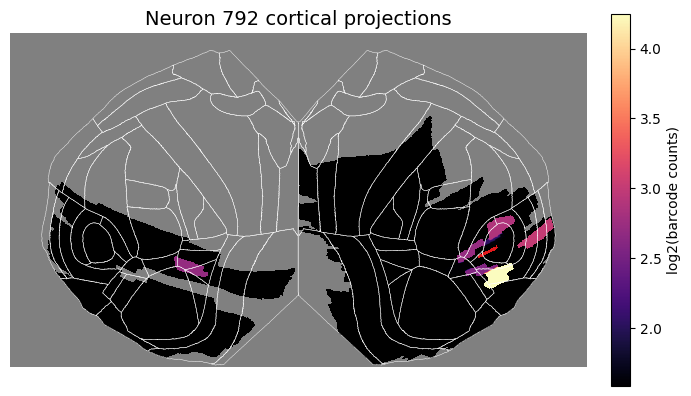

In [103]:
fig, ax = plt.subplots(figsize=(8, 8))
vmax_val=np.max(only_projections)

cmap_background = mcolors.ListedColormap(['grey', 'black'])
ax.imshow(roi_projection_max.T, cmap=cmap_background)
masked_new_mat = np.ma.masked_where(only_projections <= 0, only_projections)
new_fig =ax.imshow(masked_new_mat.T, cmap='magma', vmax=vmax_val)
masked_source_mat = np.ma.masked_where(only_source <= 0, only_source)
ax.imshow(masked_source_mat.T, cmap='Set1')
ax.axis('off')
cbar = fig.colorbar(new_fig, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("log2(barcode counts)")
ax.set_title(
            f"Neuron {barcode_index} cortical projections", fontdict={"fontsize": 14}
        )
for k, boundary_coords in bf_left_boundaries.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.3)
for k, boundary_coords in bf_right_boundaries.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.3)
plt.show()

/tmp/ipykernel_3719617/747814833.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allen_anno = np.array(ref_anno)
/tmp/ipykernel_3719617/3934375225.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z = add_z.append(
/tmp/ipykernel_3719617/3934375225.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z = add_z.append(
/tmp/ipykernel_3719617/3934375225.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z = add_z.append(
/tmp/ipykernel_3719617/3934375225.py:90: FutureWarning: The frame.a

/tmp/ipykernel_3719617/3934375225.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z = add_z.append(
/tmp/ipykernel_3719617/3934375225.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z = add_z.append(
/tmp/ipykernel_3719617/3934375225.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z = add_z.append(
/tmp/ipykernel_3719617/3934375225.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z = add_z.append(
/tmp/ipykernel_3719617/3934375225.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  add_z = add_z.append(
/tmp/ipyke

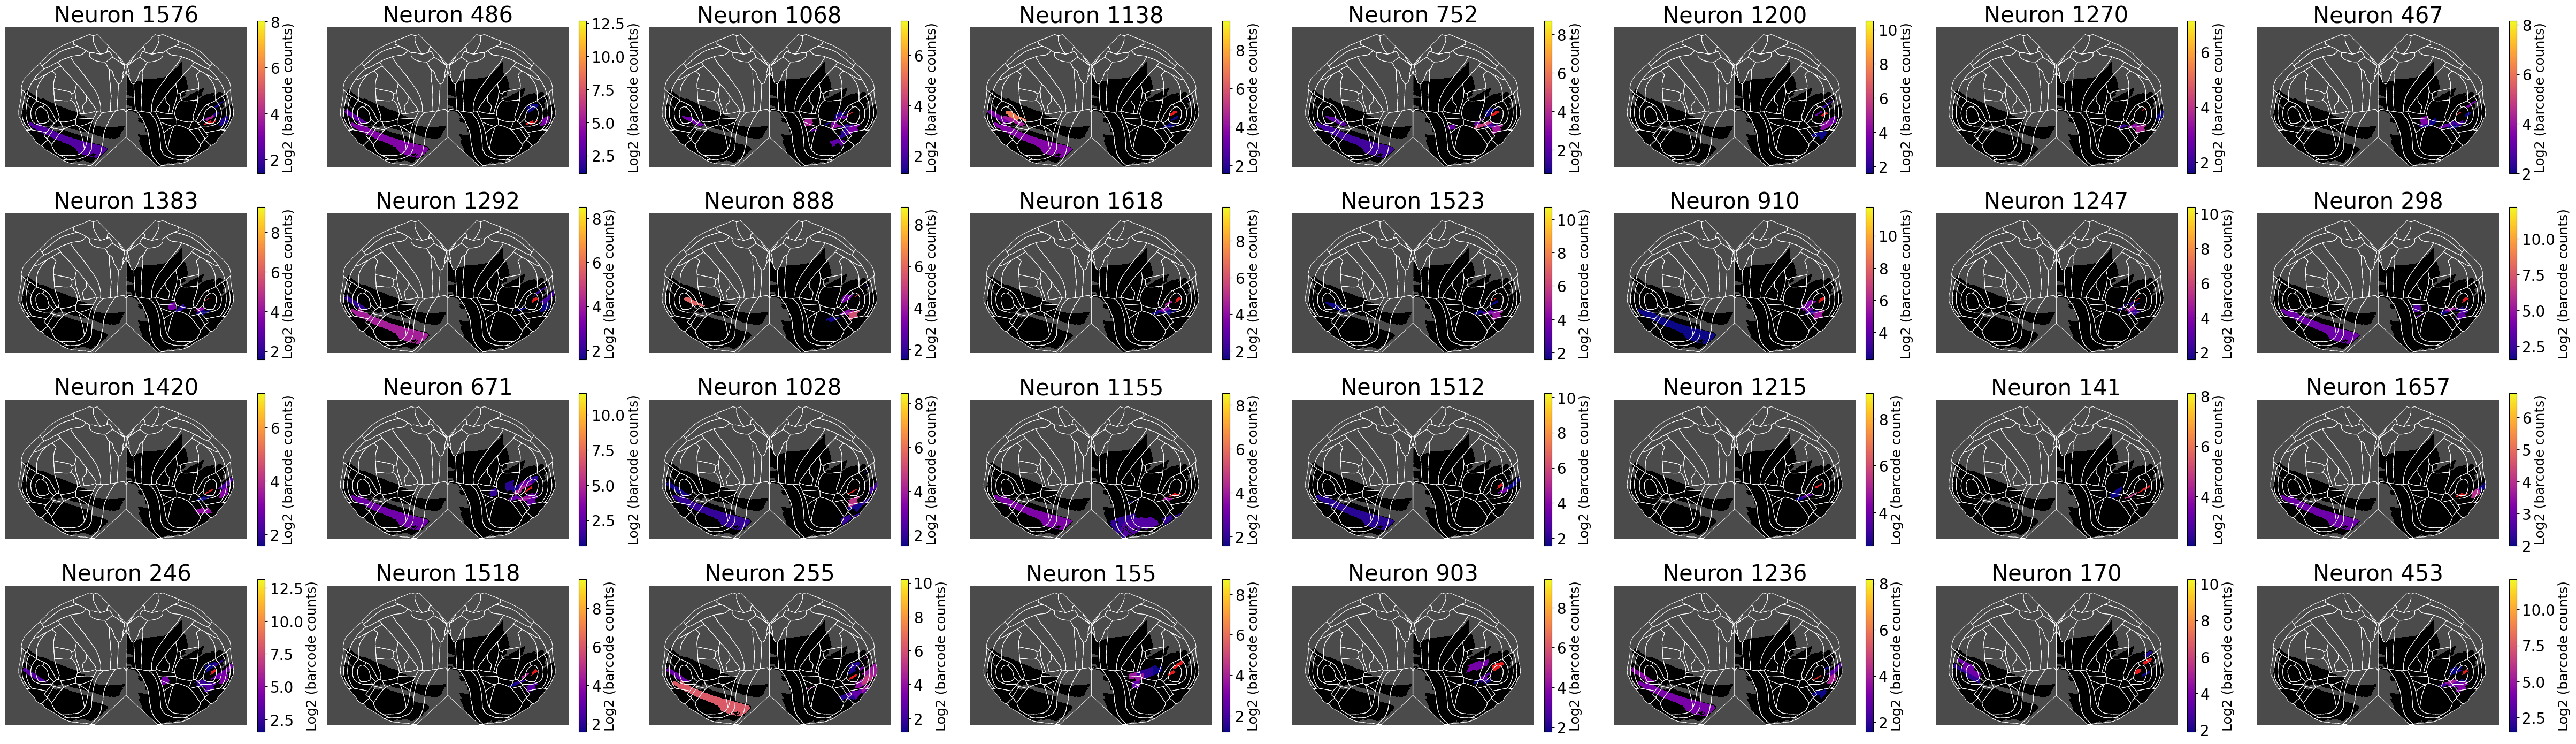

In [15]:
ref_anno = nrrd.read('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/reference/annotation_25.nrrd')
allen_anno = np.array(ref_anno)
annotation = allen_anno[0]
roi_projection_max = proj_top.project_volume(combined_samples)
# Set up the figure with 7x4 subplots
fig, axes = plt.subplots(4, 8, figsize=(48, 14))  # 7x4 grid of subplots
axes = axes.ravel()  # Flatten to easily iterate through
resolution = 25
# Loop to create each plot
for idx in range(32):
    # Randomly select a barcode index
    barcode_index = np.random.randint(len(combined_barcodes_mouse))
    mouse = combined_barcodes_mouse.iloc[barcode_index]['mouse']
    if mouse == 'FIAA45.6d':
        adjusted_bc_ind = barcode_index - len(vis_barcodes['FIAA45.6a'])
    else:
        adjusted_bc_ind = barcode_index

    barcodes_across_sample = vis_barcodes[mouse]
    lcm_directory = parameters_dict[mouse]['lcm_directory']
    empty_frame = np.zeros((528, 320, 456))
    ROI_path = pathlib.Path(lcm_directory) / "rois"
    reg_dir = pathlib.Path(lcm_directory) / "allenccf/allen_ccf_coord"
    add_z = get_z_value(
        parameters_path=f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/",
        euclidean=parameters_dict[mouse]["euclidean"]
    )
    s = parameters_dict[mouse]["s"]
    if s == "upper":
        section_start = "S"
    else:
        section_start = "s"

    for sample in barcodes_across_sample.columns:
        if barcodes_across_sample.iloc[adjusted_bc_ind][sample] > 0:
            for ROI_to_look in os.listdir(ROI_path):
                region = ROI_path / ROI_to_look
                if ROI_to_look.startswith("s0") or ROI_to_look.startswith("S0"):
                    slicename = region.stem[1:4]
                    tube = int(region.stem[5: len(region.stem)].split("TUBE", 1)[1])
                    for tube_to_group in parameters_dict[mouse]["rois_to_combine"]:
                        if tube in parameters_dict[mouse]["rois_to_combine"][tube_to_group]:
                            tube = tube_to_group
                    if tube == sample:
                        [xa, ya, za, one] = np.load(
                            reg_dir / f"allen_ccf_converted_{section_start}{slicename}.npy"
                        )
                        roi = plt.imread(ROI_path / f"{region}")
                        allencoord_roiya = roi * ya
                        allencoord_roiza = roi * za
                        allencoord_roixa = roi * xa
                        z_to_add = add_z.loc[
                            add_z["slice"] == f"{section_start}{slicename}", "amountz"
                        ].iloc[0]

                        # convert the x, y, z coordinates to pixel
                        pixcoord = []
                        for i, axis in enumerate(
                            [allencoord_roixa, allencoord_roiya, allencoord_roiza]
                        ):
                            pixel = np.array(np.round(axis / resolution), dtype=int)
                            pixel[pixel < 0] = 0
                            pixel[pixel >= empty_frame.shape[i]] = 0
                            pixcoord.append(pixel)
                        new_coord = np.zeros(pixcoord[0].shape)
                        z_add = 0

                        for stack in range(int(np.round(z_to_add / resolution))):
                            for i in range(pixcoord[0].shape[0]):
                                for j in range(pixcoord[0].shape[1]):
                                    if pixcoord[0][i, j] != 0:
                                        new_coord[i, j] = (pixcoord[0][i, j]) + z_add
                            z_add = z_add + 1
                            for k in range(pixcoord[0].shape[0]):
                                for l in range(pixcoord[0].shape[1]):
                                    x = new_coord[k, l]
                                    y = pixcoord[1][k, l]
                                    z = pixcoord[2][k, l]
                                    if x != 0 and y != 0 and z != 0:
                                        # don't include ROI regions that are outside the brain
                                        if annotation[int(x), int(y), int(z)] != 0:
                                            empty_frame[int(x), int(y), int(z)] = np.log2(
                                                barcodes_across_sample.iloc[adjusted_bc_ind][sample])

    # Convert to 10um resolution
    barcode_3D = zoom(empty_frame, zoom=zoom_factors, order=0)
    barcode_projection_max = proj_top.project_volume(barcode_3D)

    max_value = np.max(barcode_projection_max)
    only_projections = np.where(barcode_projection_max == max_value, 0, barcode_projection_max)
    only_source = np.where(barcode_projection_max == max_value, 1, 0)

    # Get the current subplot
    ax = axes[idx]

    # Plot on the current axis
    cmap_background = mcolors.ListedColormap(['#4B4B4B', 'black'])
    ax.imshow(roi_projection_max.T, cmap=cmap_background)
    masked_new_mat = np.ma.masked_where(only_projections <= 0, only_projections)
    new_fig = ax.imshow(masked_new_mat.T, cmap='plasma', vmax=max_value)
    masked_source_mat = np.ma.masked_where(only_source <= 0, only_source)
    ax.imshow(masked_source_mat.T, cmap='Set1')
    ax.axis('off')
    ax.set_title(f"Neuron {barcode_index}", fontsize=30)

    cbar = fig.colorbar(new_fig, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label("Log2 (barcode counts)", fontsize=18)
    cbar.ax.tick_params(labelsize=20)
    # Add boundaries
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.6)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.6)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


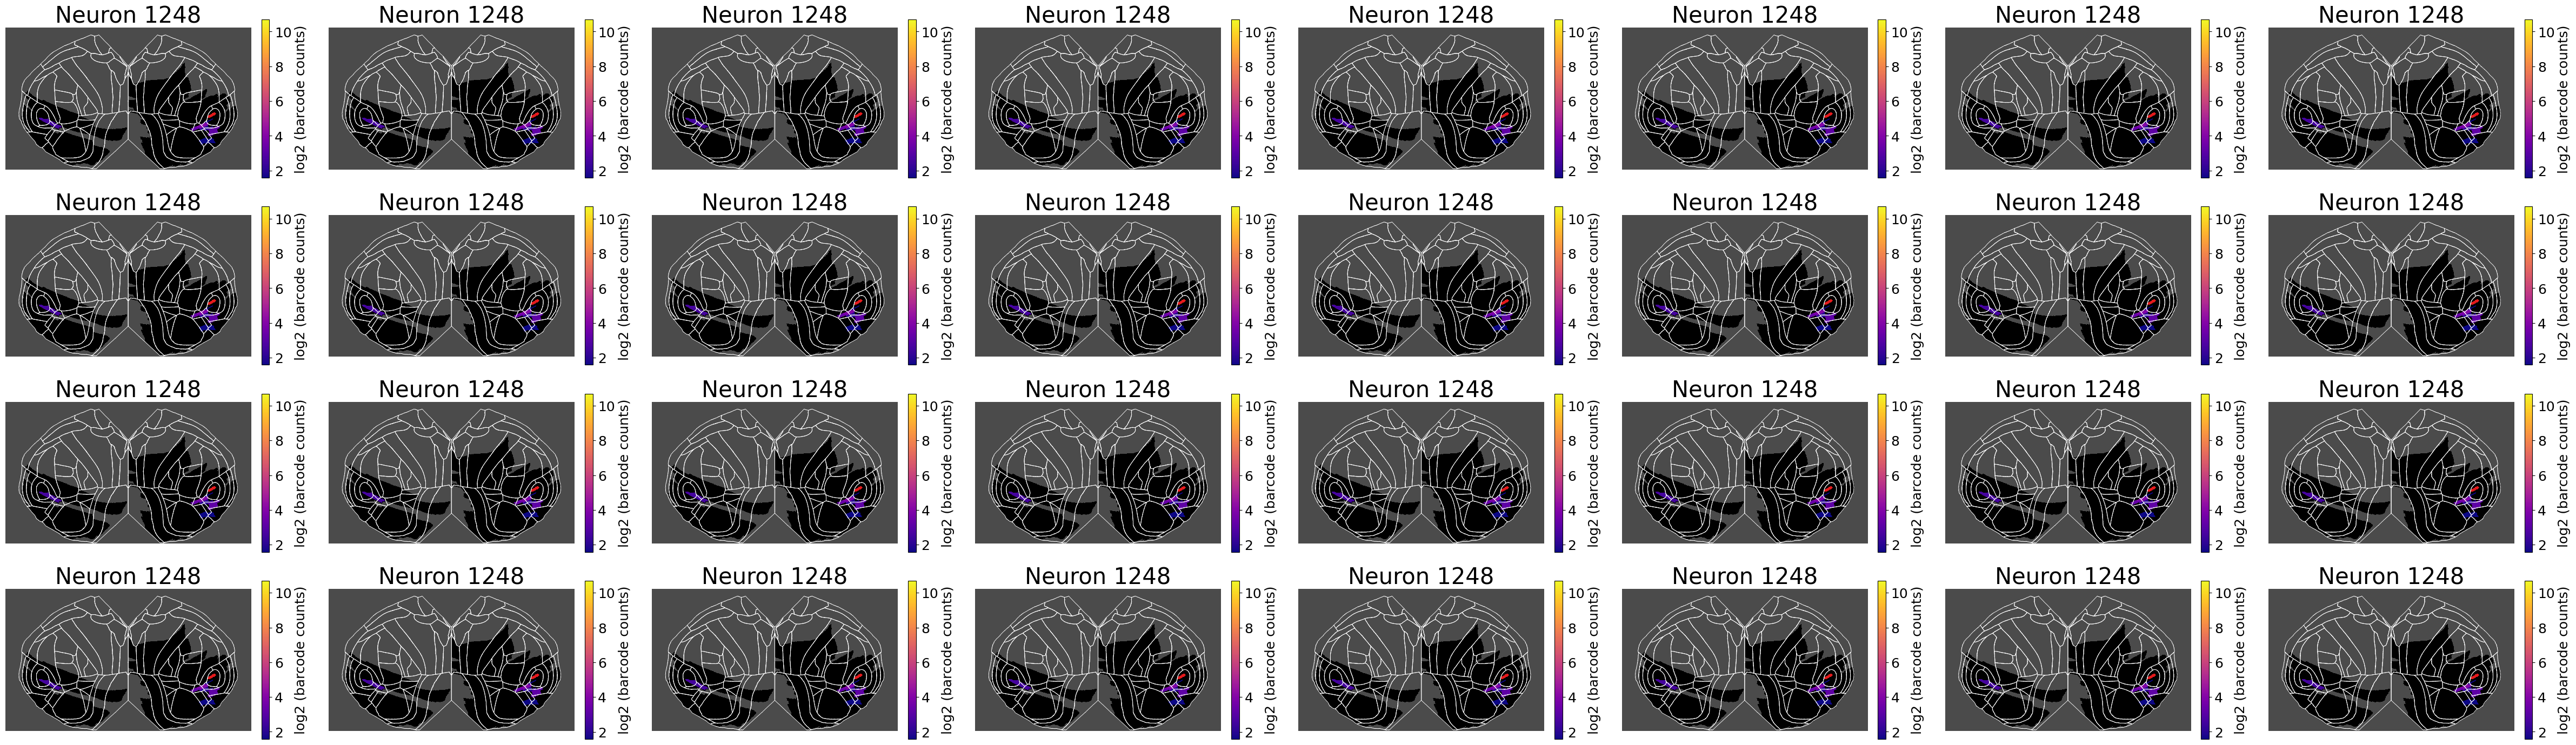

In [14]:
fig, axes = plt.subplots(4, 8, figsize=(48, 14))  # 7x4 grid of subplots
axes = axes.ravel()  # Flatten to easily iterate through
resolution = 25
# Loop to create each plot
for idx in range(32):
    ax = axes[idx]

    # Plot on the current axis
    cmap_background = mcolors.ListedColormap(['#4B4B4B', 'black'])
    ax.imshow(roi_projection_max.T, cmap=cmap_background)
    masked_new_mat = np.ma.masked_where(only_projections <= 0, only_projections)
    new_fig = ax.imshow(masked_new_mat.T, cmap='plasma', vmax=max_value)
    masked_source_mat = np.ma.masked_where(only_source <= 0, only_source)
    ax.imshow(masked_source_mat.T, cmap='Set1')
    ax.axis('off')
    ax.set_title(f"Neuron {barcode_index}", fontsize=30)

    cbar = fig.colorbar(new_fig, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label("log2 (barcode counts)", fontsize=18)
    cbar.ax.tick_params(labelsize=18)
    # Add boundaries
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.6)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.6)
    
# Adjust layout and show the figure
plt.tight_layout()
plt.show()


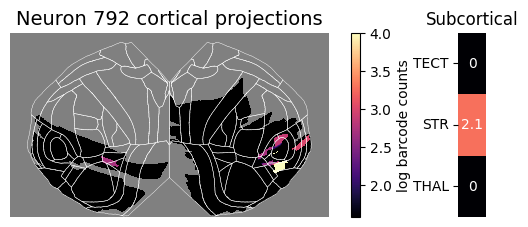

In [92]:

vmax_val = 3
i = 0

fig = plt.figure(figsize=(7, 100))
gs = fig.add_gridspec(50, 2, width_ratios=[2, 0.1])
ax1 = fig.add_subplot(gs[i, 0])
ax2 = fig.add_subplot(gs[i, 1])

# Plot the base layer with ROI_projection_max
cmap_background = mcolors.ListedColormap(['grey', 'black'])
ax1.imshow(roi_projection_max.T, cmap=cmap_background)

# Overlay new_mat on top of this
masked_new_mat = np.ma.masked_where(barcode_projection_max <= 0, barcode_projection_max)
new_fig = ax1.imshow(masked_new_mat.T, cmap='magma', vmax=4)

# Remove axes for better visualization
ax1.axis('off')

cbar = fig.colorbar(new_fig, ax=ax1, fraction=0.03, pad=0.04)
cbar.set_label("log barcode counts")
ax1.set_title(f"Neuron {barcode_index} cortical projections", fontdict={"fontsize": 14})

for k, boundary_coords in bf_left_boundaries.items():
    ax1.plot(*boundary_coords.T, c="white", lw=0.3)
for k, boundary_coords in bf_right_boundaries.items():
    ax1.plot(*boundary_coords.T, c="white", lw=0.3)

# Subplot - Seaborn heatmap
sub_cort_heat = pd.DataFrame(columns=sub_cortical.keys(), dtype="float")
for col in sub_cort_heat.columns:
    sub_cort_heat.loc[0, col] = barcodes_across_sample.iloc[adjusted_bc_ind][sub_cortical_updated[col]].sum()

# Remove x-tick labels and numbers for ax2
sb.heatmap(
    sub_cort_heat.T,
    annot=True,
    cmap='magma',
    cbar=False,
    vmax=vmax_val
)

ax2.set_title("Subcortical")
ax2.xaxis.set_ticks_position('none')  # Remove ticks completely
ax2.set_xticklabels([])  # Ensure x-tick labels are removed
ax2.tick_params(axis='x', which='both', bottom=False, top=False)  # Disable ticks on x-axis
ax2.set_yticklabels(labels=sub_cortical.keys(), rotation=0)
plt.tight_layout()
plt.show()


In [13]:
sample = 63
np.log2(barcodes_across_sample.iloc[adjusted_bc_ind][sample])

1.584962500721156

In [12]:
barcodes_across_sample.iloc[adjusted_bc_ind][barcodes_across_sample.iloc[adjusted_bc_ind]>0]

43     16.000000
58      3.000000
63      3.000000
86      4.000000
103    10.625224
112     4.923611
122     5.095364
Name: GGCCTGTGCCTCAAATAATTGCCTTTTGCATC, dtype: float64

In [82]:
ROI_projection_max2 = proj_top.project_volume(combined_samples)

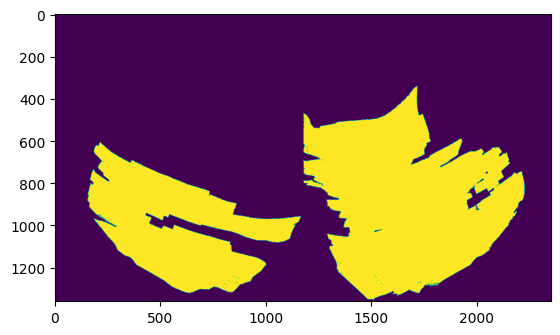

In [83]:
plt.imshow(ROI_projection_max2.T)

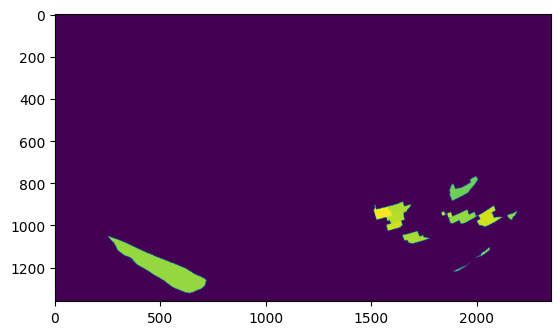

In [84]:
plt.imshow(new_mat)

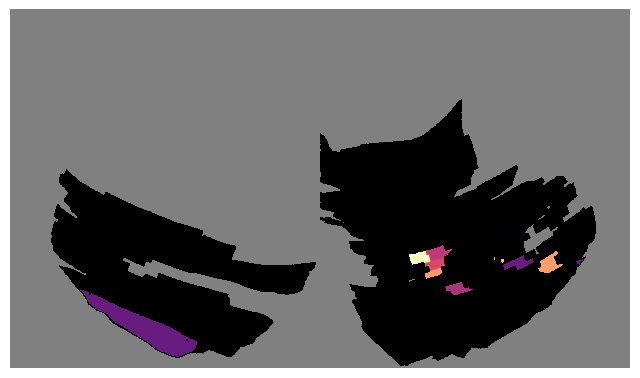

In [88]:
 fig, ax = plt.subplots(figsize=(8, 8))

# Plot the base layer with ROI_projection_max2
# Create a colormap for the background: grey for 0, black for 1
cmap_background = mcolors.ListedColormap(['grey', 'black'])
# Plot ROI_projection_max2 with this colormap
ax.imshow(ROI_projection_max2.T, cmap=cmap_background)

# Overlay new_mat on top of this
# Use a masked array to only show positive values in new_mat
masked_new_mat = np.ma.masked_where(new_mat <= 0, new_mat)
# Use the magma colormap and add transparency
ax.imshow(masked_new_mat, cmap='magma', vmax=1)

# Remove axes for better visualization
ax.axis('off')

# Display the plot
plt.show()

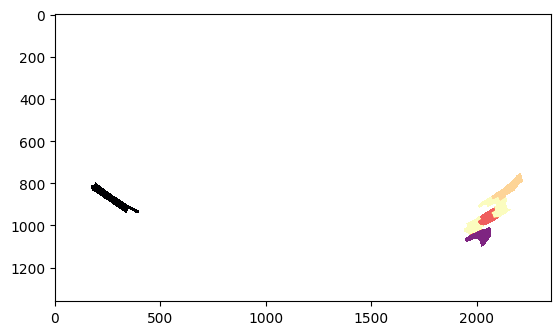

In [79]:
plt.imshow(masked_new_mat, cmap='magma', vmax=2)

In [80]:
np.unique(masked_new_mat[700:1000, 0:500])

masked_array(data=[1.3862943611198906, --],
             mask=[False,  True],
       fill_value=1e+20)

In [41]:
combined_barcodes_mouse_d.iloc[6]

mouse    6
Name: 6, dtype: int64

In [43]:
combined_barcodes_mouse_old = pd.DataFrame({'mouse': xsdfa})

In [44]:
combined_barcodes_mouse_old.iloc[1]

mouse    6
Name: 1, dtype: int64

In [42]:
6-len([0 , 1, 2, 3, 4])

1

In [30]:
combined_barcodes_mouse.iloc[5]['mouse']

'FIAA45.6a'

In [33]:
4794 -len(a)

0